<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureEngineering/Discretisation/4_2_Equal_frequency_discretisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called **binning**, where bin is an alternative name for interval.


### Discretisation helps handle outliers and may improve value spread in skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretisation methods

- Equal width discretisation
- Equal frequency discretisation
- K-means discretisation

#### Supervised discretisation methods

- Discretisation using decision trees


In this lecture, I will describe **equal frequency discretisation**.


## Equal frequency discretisation

Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations. This is particularly useful for skewed variables as it spreads the observations over the different bins equally. We find the interval boundaries by determining the quantiles.

Equal frequency discretisation using quantiles consists of dividing the continuous variable into N quantiles, N to be defined by the user.

Equal frequency binning is straightforward to implement and by spreading the values of the observations more evenly it may help boost the algorithm's performance. This arbitrary binning may also disrupt the relationship with the target.


## Titanic dataset

In [1]:
!pip install feature_engine
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisers import EqualFrequencyDiscretiser

  Created wheel for numpydoc: filename=numpydoc-0.9.2-cp36-none-any.whl size=31893 sha256=be6cfc4bc0593c0aedfbd623d3ae6e77d715dc7ba8a1a978662c2996dbb99d57
  Stored in directory: /root/.cache/pip/wheels/96/f3/52/25c8e1f40637661d27feebc61dae16b84c7cdd93b8bc3d7486
Successfully built numpydoc


In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('titanic_train.csv',
                   usecols=['Age', 'Fare', 'Survived'])

data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [0]:
def impute_na(data, variable):
    # function to fill NA with a random sample

    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [0]:
# replace NA in both train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

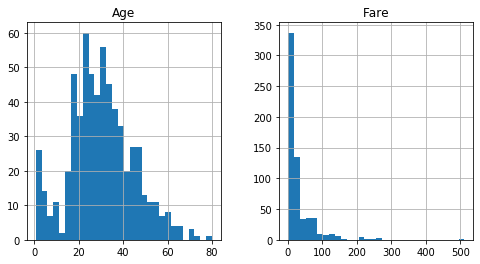

In [7]:
# let's explore the distribution of age

X_train[['Age', 'Fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretisation with pandas and NumPy

The interval limits are the quantile limits. We can find those out with pandas qcut.

In [9]:
# let's use pandas qcut (quantile cut) and I indicate that
# we want 10 bins.

# retbins = True indicates that I want to capture the limits
# of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(
    X_train['Age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([Age_disccretised, X_train['Age']], axis=1).head(10)

,Age,Age
857,"(48.8, 80.0]",51.0
52,"(48.8, 80.0]",49.0
386,"(0.669, 14.6]",1.0
124,"(48.8, 80.0]",54.0
578,"(48.8, 80.0]",65.0
549,"(0.669, 14.6]",8.0
118,"(23.0, 26.0]",24.0
12,"(19.0, 23.0]",20.0
157,"(29.0, 33.0]",30.0
127,"(23.0, 26.0]",24.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 29 was placed in the 26-30 interval, whereas age 63 was placed into the 49-80 interval. 

Note how the interval widths are different.

We can visualise the interval cut points below:

In [10]:
intervals

array([ 0.67, 14.6 , 19.  , 23.  , 26.  , 29.  , 33.  , 36.  , 42.  ,
       48.8 , 80.  ])

And because we generated the bins using the quantile cut method, we should have roughly the same amount of observations per bin. See below.

In [11]:
# roughly the same number of passengers per interval

Age_disccretised.value_counts()

(29.0, 33.0]     69
(19.0, 23.0]     69
(14.6, 19.0]     65
(48.8, 80.0]     63
(0.669, 14.6]    63
(33.0, 36.0]     62
(36.0, 42.0]     61
(26.0, 29.0]     59
(23.0, 26.0]     58
(42.0, 48.8]     54
Name: Age, dtype: int64

In [12]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [13]:
Age_disccretised, intervals = pd.qcut(X_train['Age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

Age_disccretised.head()

857    Q10
52     Q10
386     Q1
124    Q10
578    Q10
Name: Age, dtype: category
Categories (10, object): [Q1 < Q2 < Q3 < Q4 ... Q7 < Q8 < Q9 < Q10]

In [14]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_test['Age_disc_label'] = pd.cut(x = X_test['Age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['Age'], bins=intervals)

X_test.head(10)

,Age,Fare,Age_disc_label,Age_disc
495,37.0,14.4583,Q8,"(36.0, 42.0]"
648,21.0,7.5500,Q3,"(19.0, 23.0]"
278,7.0,29.1250,Q1,"(0.67, 14.6]"
31,35.0,146.5208,Q7,"(33.0, 36.0]"
255,29.0,15.2458,Q5,"(26.0, 29.0]"
298,28.0,30.5000,Q5,"(26.0, 29.0]"
609,40.0,153.4625,Q8,"(36.0, 42.0]"
318,31.0,164.8667,Q6,"(29.0, 33.0]"
484,25.0,91.0792,Q4,"(23.0, 26.0]"
367,32.0,7.2292,Q6,"(29.0, 33.0]"


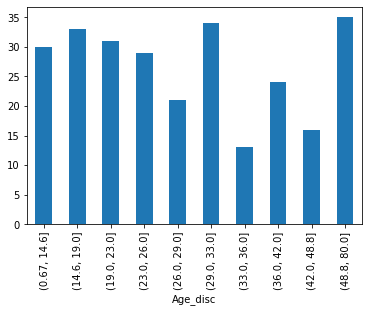

In [15]:
# let's check that we have equal frequency (equal number of observations per bin)
X_test.groupby('Age_disc')['Age'].count().plot.bar()

We can see that the top intervals have less observations. This may happen with skewed distributions if we try to divide in a high number of intervals. To make the value spread  more homogeneous, we should discretise in less intervals.

## Equal frequency discretisation with Feature-Engine

In [16]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [0]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [18]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualFrequencyDiscretiser(q=10, variables = ['Age', 'Fare'])

disc.fit(X_train)

EqualFrequencyDiscretiser(q=10, return_object=False, variables=['Age', 'Fare'])

In [19]:
# in the binner dict, we can see the limits of the intervals. Note
# that the intervals have different widths

disc.binner_dict_

{'Age': [-inf,
  13.200000000000003,
  19.0,
  22.0,
  26.0,
  29.0,
  32.0,
  36.0,
  41.60000000000002,
  49.0,
  inf],
 'Fare': [-inf,
  7.72584,
  7.88252,
  8.05,
  12.130000000000008,
  15.0,
  23.45,
  27.75,
  46.9,
  77.17584000000004,
  inf]}

In [0]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [0]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,2,1
686,2,1


Text(0, 0.5, 'Number of observations per bin')

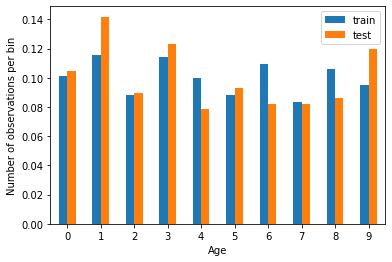

In [21]:
# and now let's explore the number of observations per bucket

t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

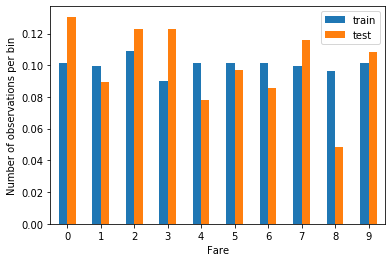

In [22]:
t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Note how equal frequency discretisation obtains a better value spread across the different intervals.

## Equal frequency discretisation with Scikit-learn

In [23]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [0]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')

In [25]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

disc.fit(X_train[['Age', 'Fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='quantile')

In [26]:
disc.bin_edges_

array([array([ 0.67, 13.2 , 19.  , 22.  , 26.  , 29.  , 32.  , 36.  , 41.6 ,
       49.  , 80.  ]),
       array([  0.     ,   7.72584,   7.88252,   8.05   ,  12.13   ,  15.     ,
        23.45   ,  27.75   ,  46.9    ,  77.17584, 512.3292 ])],
      dtype=object)

In [27]:
train_t = disc.transform(X_train[['Age', 'Fare']])

train_t = pd.DataFrame(train_t, columns = ['Age', 'Fare'])

train_t.head()

,Age,Fare
0,9.0,6.0
1,9.0,8.0
2,0.0,8.0
3,9.0,9.0
4,1.0,4.0


In [0]:
test_t = disc.transform(X_test[['Age', 'Fare']])

test_t = pd.DataFrame(test_t, columns = ['Age', 'Fare'])

Text(0, 0.5, 'Number of observations per bin')

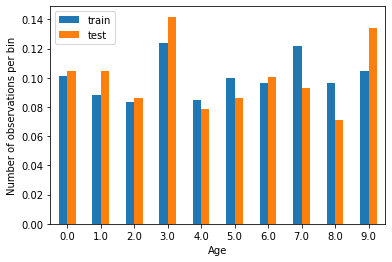

In [29]:
t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

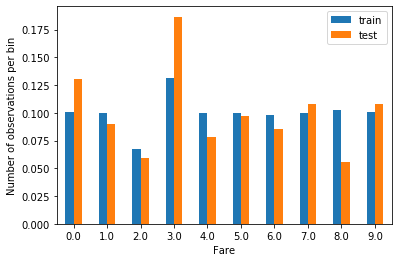

In [30]:
t1 = train_t.groupby(['Fare'])['Fare'].count() / len(train_t)
t2 = test_t.groupby(['Fare'])['Fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')